### Reading images

In [1]:
def read_image(prefix ,source_path):
    #print(source_path)
    filename = source_path.split('/')[-1]
    #print(filename)
    filename = prefix + filename.split('\\')[-1]
    #print(filename)
    image = cv2.imread(filename)
    return image

In [6]:
import csv
import cv2
import numpy as np
from tqdm import tqdm

def read_dataset(prefix, lines, images, measurements):

    with open( prefix + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    #for line in lines:
    for i in tqdm(range(0, len(lines), 1)):
        steering_center = float(lines[i][3])
        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # Center
        images.append(read_image( prefix + 'IMG/', lines[i][0]))
        measurements.append(steering_center)
        # Left
        images.append(read_image( prefix + 'IMG/', lines[i][1]))
        measurements.append(steering_left)
        # Right
        images.append(read_image( prefix + 'IMG/', lines[i][2]))
        measurements.append(steering_right)

In [7]:
lines = []
images = []
measurements = []

# First dataset
read_dataset("./data/", lines, images, measurements)

# Smooth driving


100%|██████████| 8036/8036 [00:22<00:00, 360.83it/s]


### Image augmentation

In [8]:
def image_augmentation(images, measurements):   
    augmented_images, augmented_measurements = [], []
    # for image, measurement in zip(images, measurements, len(images)):
    for i in tqdm(range(0, len(images), 1)):
        image = images[i]
        measurement = measurements[i]
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image, flipCode=1))
        augmented_measurements.append(measurement*-1.0)
        
    return augmented_images, augmented_measurements

100%|██████████| 24108/24108 [00:04<00:00, 5862.92it/s]


In [13]:
augmented_images, augmented_measurements = image_augmentation(images, measurements)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

NameError: name 'image_augmentation' is not defined

### Model

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Cropping2D

model = Sequential()
# Normalize and mean centering the data 
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Conv2D(24, (5, 5), strides=(2,2), activation = 'relu'))
model.add(Conv2D(36, (5, 5), strides=(2,2), activation = 'relu'))
model.add(Conv2D(48, (5, 5), strides=(2,2), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=10, verbose = 2)
model.save('model.h5')

Train on 38572 samples, validate on 9644 samples
Epoch 1/10
184s - loss: 0.0176 - val_loss: 0.0192
Epoch 2/10
185s - loss: 0.0148 - val_loss: 0.0215
Epoch 3/10
187s - loss: 0.0136 - val_loss: 0.0179
Epoch 4/10
187s - loss: 0.0126 - val_loss: 0.0192
Epoch 5/10
188s - loss: 0.0117 - val_loss: 0.0206
Epoch 6/10
190s - loss: 0.0109 - val_loss: 0.0198
Epoch 7/10
191s - loss: 0.0103 - val_loss: 0.0188
Epoch 8/10
190s - loss: 0.0094 - val_loss: 0.0195
Epoch 9/10
191s - loss: 0.0087 - val_loss: 0.0189
Epoch 10/10
191s - loss: 0.0081 - val_loss: 0.0181


### History

dict_keys(['loss', 'val_loss'])


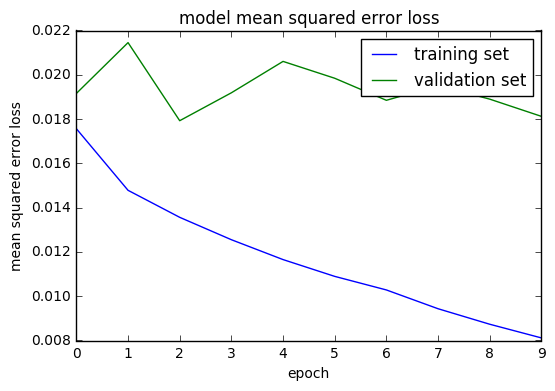

In [12]:
from keras.models import Model
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()